In [1]:
# Kaggle에서는 필요없음 
# !pip install torch 
# !pip install torchvision

### 패션 MNIST
- 구두, 가방, 옷 등의 이미지로 구성
- 총 10개의 class
- 28 * 28 pixel = 784개의 Feature
- Sample수는 70000개 이다. 

In [2]:
# 데이터 불러오기
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# 학습 데이터 불러오기
train_data = datasets.FashionMNIST(
                root = "./Data", # 데이터가 저장될 경로 
                train = True, # True이면 학습데이터, False이면 테스트 데이터 
                download = True, # True이면 데이터가 없을 경우 자동 다운로드 
                transform = ToTensor() # 이미지를 텐서로 변환 
)

100%|██████████| 26.4M/26.4M [00:00<00:00, 117MB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.62MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 57.1MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.3MB/s]


In [4]:
# 테스트 데이터 불러오기
test_data = datasets.FashionMNIST(
                root = "./Data", # 데이터가 저장될 경로 
                train = False, # True이면 학습데이터, False이면 테스트 데이터 
                download = True, # True이면 데이터가 없을 경우 자동 다운로드 
                transform = ToTensor() # 이미지를 텐서로 변환 
)

In [5]:
# train_data의 data와 label 크기 확인

print(train_data.data.shape)
print(train_data.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [6]:
# test_data의 data와 label 크기 확인

print(test_data.data.shape)
print(test_data.targets.shape)

torch.Size([10000, 28, 28])
torch.Size([10000])


In [7]:
# Data와 Target의 변수 재정의
train_input = train_data.data
train_target = train_data.targets

test_input = test_data.data
test_target = test_data.targets

In [8]:
# target data의 확인

print(train_target[:10])

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])


- 0: 티셔츠
- 1: 바지
- 2: 스웨터
- 3: 드레스
- 4: 코트
- 5: 샌달
- 6: 셔츠
- 7: 스니커즈
- 8: 가방
- 9: 앵글부츠 

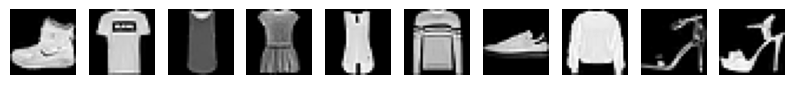

In [9]:
# train_data의 target 모양 10개만 출력 해보기

import matplotlib.pyplot as plt

_, axs = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    axs[i].imshow(train_input[i], cmap='gray')
    axs[i].axis('off')

plt.show()

### train_data의 target 종류 및 갯수 파악

In [10]:
import numpy as np

print(np.unique(train_target, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


### 데이터 정규화 및 2차원 행렬로 만들기

In [11]:
train_scaled = train_input / 255.0 
train_scaled = train_scaled.reshape(-1, 28*28) # [60000, 28, 28]

test_scaled = test_input / 255.0 
test_scaled = test_scaled.reshape(-1, 28*28) # [60000, 28, 28]

In [12]:
# Dimension 확인

print(train_scaled.shape)
print(test_scaled.shape)

torch.Size([60000, 784])
torch.Size([10000, 784])


---
# 인공신경망
- 가장 간단한 인공신경망은 출력층이 1개 있는 인공신경망 이다.
- 경사 하강법을 사용한 로지스틱 회귀나 경사하강법을 사용한 선형회귀와 거의 동일한 구조이다. 

In [13]:
# Module 불러오기
import torch
import torch.nn as nn # Neural Network
import torch.optim as optim # Optimizer(ex: SGD, Adam, ...)
from torch.utils.data import TensorDataset, DataLoader

In [14]:
# Train data를 훈련데이터와 검증 데이터로 나누기

from sklearn.model_selection import train_test_split

train_scaled, val_scaled, train_target, val_target = train_test_split(
                                                        train_scaled, 
                                                        train_target,
                                                        test_size = 0.2,
                                                        random_state = 42
)

In [15]:
# 분리후의 Dimension 확인
print(train_scaled.shape)
print(train_target.shape)
print(val_scaled.shape)
print(val_target.shape)

torch.Size([48000, 784])
torch.Size([48000])
torch.Size([12000, 784])
torch.Size([12000])


In [16]:
# Dataset 및 DataLoader 생성

batch_size = 32 # mini batch
train_dataset = TensorDataset(train_scaled, train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_scaled, val_target)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

shuffle=True로 설정하면 매 Epoch마다 데이터셋 전체가 한번 섞입니다.    
이는 각 batch가 서로 다른 샘플조합을 가지게 하여 모델 학습에 변동성을 줍니다.     
모델이 데이터의 순서에 의존하지 않고 일반화 능력을 향상 시키는데 도움이 됩니다.     
과대적합(Overfitting)을 방지하는데 도움이 됩니다.      
일반적으로 학습 데이터에는 shuffle=True를 사용하고, 검증이나 테스트 데이터에는 shuffle=False로 사용하는 것이 좋습니다.     

----
### 모델 만들기

In [17]:
class SimpleModel(nn.Module):
    def __init__(self): # 생성자(Constructor)
        super(SimpleModel, self).__init__()
        self.dense = nn.Linear(28*28, 10) # 28*28=784: Feature, 10: Target
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.dense(x) # 입력층과 출력층 구성의 완전 연결층 1개 
        x = self.softmax(x)
        return x 

In [18]:
# 모델의 인스턴스(객체, Object) 생성
model = SimpleModel()

In [19]:
# 손실함수와 옵티마이저 정의 
criterion = nn.CrossEntropyLoss() # 손실함수 
optimizer = optim.Adam(model.parameters()) # Adam / optim.SGD()

In [20]:
# 현재의 Target 확인
print(train_target[:10])

tensor([7, 3, 5, 8, 6, 9, 3, 3, 9, 9])


---
### 모델 훈련

In [21]:
# 학습 함수 정의
def train(model, train_loader, criterion, optimizer, device):
    model.train() # 뉴런들이 훈련모드로 동작하도록 설정 
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad() # 이전 반복에서 계산된 그래디언트를 초기화 
        outputs = model(inputs) # 내부적으로 model.forward(inputs) 호출하여 예측값 얻음 
        loss = criterion(outputs, targets) # 모델의 예측값과 실제 타겟 간의 손실을 계산 
        loss.backward() # 손실에 대한 그래디언트를 계산하고 역전파 
        optimizer.step() # 계산된 그래디언트를 사용하고 모델의 파라미터를 업데이트 
    return loss.item() # 현재 배치의 손실값을 반환 

In [22]:
# 평가함수 
def evaluate(model, val_loader, criterion, device):
    model.eval() # 평가모드로 동작하도록 설정 
    total_loss = 0 # 전체 손실 합계 
    correct = 0 # 정확하게 예측한 샘플 수 
    total = 0 # 전체 샘플 수
    with torch.no_grad() : # 평가 중에는 그래디언트 계산이 필요 없으므로 메모리 사용량 및 연산 속도 향상
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs) # 예측값 발생 
            loss = criterion(outputs, targets) # 손실계산
            total_loss += loss.item() # 전체 손실에 더하기 
            _, predicted = outputs.max(1) # 전체 샘플에 대해 가장 높은 확률을 가진 인덱스 
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item() # 예측값과 실제값이 일치하는 경우 True를 발생 
        return total_loss/len(val_loader), correct/total # 평균손실과 정확도 

### 학습 및 평가 실행

In [24]:
# device의 정의
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [25]:
model.to(device)

SimpleModel(
  (dense): Linear(in_features=784, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [26]:
num_epochs = 100

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    print(f"Epoch[{epoch+1}/{num_epochs}], Loss :{train_loss:.4f}")

Epoch[1/100], Loss :1.6332
Epoch[2/100], Loss :1.5450
Epoch[3/100], Loss :1.7056
Epoch[4/100], Loss :1.6377
Epoch[5/100], Loss :1.7523
Epoch[6/100], Loss :1.6575
Epoch[7/100], Loss :1.7735
Epoch[8/100], Loss :1.5735
Epoch[9/100], Loss :1.5564
Epoch[10/100], Loss :1.6147
Epoch[11/100], Loss :1.5644
Epoch[12/100], Loss :1.6018
Epoch[13/100], Loss :1.6254
Epoch[14/100], Loss :1.6772
Epoch[15/100], Loss :1.5359
Epoch[16/100], Loss :1.7273
Epoch[17/100], Loss :1.5273
Epoch[18/100], Loss :1.6828
Epoch[19/100], Loss :1.5034
Epoch[20/100], Loss :1.6080
Epoch[21/100], Loss :1.6595
Epoch[22/100], Loss :1.5698
Epoch[23/100], Loss :1.6164
Epoch[24/100], Loss :1.6138
Epoch[25/100], Loss :1.6080
Epoch[26/100], Loss :1.5323
Epoch[27/100], Loss :1.5818
Epoch[28/100], Loss :1.5732
Epoch[29/100], Loss :1.5967
Epoch[30/100], Loss :1.4892
Epoch[31/100], Loss :1.5399
Epoch[32/100], Loss :1.6243
Epoch[33/100], Loss :1.5595
Epoch[34/100], Loss :1.5069
Epoch[35/100], Loss :1.5605
Epoch[36/100], Loss :1.6270
E

In [27]:
# 훈련 평가
train_loss, train_accuracy = evaluate(model, train_loader, criterion, device)
print(f"Loss : {train_loss:.4f}, Accuracy : {train_accuracy:.4f}")

Loss : 1.5721, Accuracy : 0.8953


In [29]:
# 검증 평가
val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
print(f"Loss : {val_loss:.4f}, Accuracy : {val_accuracy:.4f}")

Loss : 1.6017, Accuracy : 0.8616


In [30]:
# 일반화 평가
test_dataset = TensorDataset(test_scaled, test_target)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"Loss : {test_loss:.4f}, Accuracy : {test_accuracy:.4f}")

Loss : 1.6117, Accuracy : 0.8510
